SMOTE failed due to low sample size. Using Random Oversampling instead.
Overall Accuracy: 0.70
Overall Precision: 0.71
Overall Recall: 0.70
Overall F1 Score: 0.69


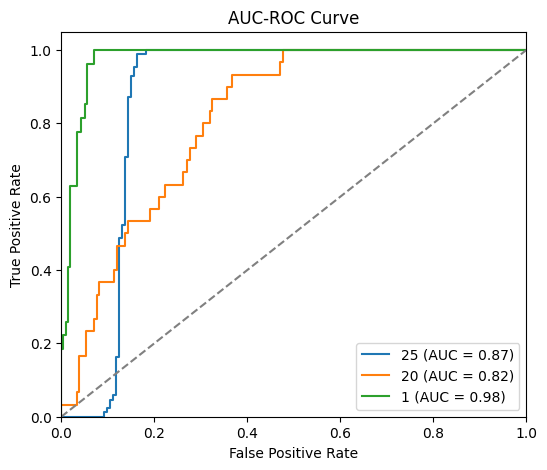

Gene 25 AUC: 0.87, Test Accuracy: 0.90
Gene 20 AUC: 0.82, Test Accuracy: 0.97
Gene 1 AUC: 0.98, Test Accuracy: 0.94


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Load the dataset
df = pd.read_csv("/Users/raghav/Documents/GitHub/ACSEF/newACSEFDataframe.csv")  # Change this to your actual file path

# Handle missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# Identify categorical columns and encode them
label_encoders = {}
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Convert target variable to numeric
le_genes = LabelEncoder()
df["MostVariableGene_Encoded"] = le_genes.fit_transform(df["MostVariableGene"].astype(str))

gene_mapping = dict(zip(df["MostVariableGene_Encoded"], df["MostVariableGene"].astype(str)))

# Define target and features
X = df.drop(columns=["MostVariableGene", "case_id", "project_id", "icd_10_code"], errors='ignore')
y = df["MostVariableGene_Encoded"]

# Ensure all features are numeric
assert X.select_dtypes(exclude=[np.number]).empty, "Non-numeric columns remain in X!"

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and unseen test set
X_train, X_unseen, y_train, y_unseen = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance dynamically
try:
    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=1)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) 
except ValueError:
    print("SMOTE failed due to low sample size. Using Random Oversampling instead.")
    ros = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).view(-1, 1)
X_unseen_tensor = torch.tensor(X_unseen, dtype=torch.float32)
y_unseen_tensor = torch.tensor(y_unseen.values, dtype=torch.float32).view(-1, 1)

# Create datasets and loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
unseen_dataset = TensorDataset(X_unseen_tensor, y_unseen_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
unseen_loader = DataLoader(unseen_dataset, batch_size=16, shuffle=False)

# Identify top 5 genes by count
class_gene_association = pd.DataFrame({'Gene': df["MostVariableGene"], 'Class': y})
class_gene_counts = class_gene_association.groupby(['Class']).size().reset_index(name='Count')
top_5_gene_ids = class_gene_counts.nlargest(5, "Count")["Class"].tolist()

# Define the neural network model
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Initialize the model
num_classes = len(np.unique(y_train_resampled))
input_size = X_train_resampled.shape[1]
model = NeuralNet(input_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze().long())
        loss.backward()
        optimizer.step()

# Evaluate on unseen data
model.eval()
y_true, y_pred_prob = [], []
with torch.no_grad():
    for inputs, targets in unseen_loader:
        outputs = model(inputs)
        y_true.extend(targets.numpy())
        y_pred_prob.extend(outputs.numpy())

# Convert predictions to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_true, y_pred)
overall_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
overall_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
overall_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Overall Accuracy: {overall_accuracy:.2f}")
print(f"Overall Precision: {overall_precision:.2f}")
print(f"Overall Recall: {overall_recall:.2f}")
print(f"Overall F1 Score: {overall_f1:.2f}")

# Convert y_true to binary matrix
y_true_bin = label_binarize(y_true, classes=np.unique(y))
y_pred_prob = np.array(y_pred_prob)

# Compute ROC AUC for top 5 genes only
roc_auc_scores = []
plt.figure(figsize=(6,5))
test_accuracies = {}

for class_id in top_5_gene_ids:
    gene_id = gene_mapping[class_id]
    fpr, tpr, _ = roc_curve(y_true_bin[:, class_id], y_pred_prob[:, class_id])
    roc_auc = auc(fpr, tpr)
    
    if roc_auc >= 0.80:
        roc_auc_scores.append((gene_id, roc_auc))
        plt.plot(fpr, tpr, label=f'{gene_id} (AUC = {roc_auc:.2f})')
        # Calculate accuracy for this specific gene
        test_accuracies[gene_id] = accuracy_score(y_true_bin[:, class_id], (y_pred == class_id))

# Plot AUC-ROC Curve
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Display AUC and accuracy for filtered genes
for gene_id, auc_score in roc_auc_scores:
    print(f"Gene {gene_id} AUC: {auc_score:.2f}, Test Accuracy: {test_accuracies[gene_id]:.2f}")


In [23]:
from sklearn.metrics import f1_score

f1_macro = f1_score(y_true, y_pred, average='macro')
print(f"F1 Macro Score: {f1_macro:.2f}")

F1 Macro Score: 0.32
